In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import style
style.set_style()

from rich import print

In [2]:
df_UV = pd.read_csv("../data/RC_light.csv", index_col=0).drop(columns=['T', 'exp'])
df_UV = df_UV.drop(columns=['AVNIPFKVHLRCKAAFC', 'SSVRWWSDDEWRW', 'CCFSWRCRC', 'CCF(pS)WRCRC', 'IYPFVEPI', 'TTMHPRL','TKIFKI'])
df_UV = df_UV.assign(Pulse = df_UV['Pulse']/60)
df_UV = df_UV.sort_values(by='Pulse')

# Filter out non-resolvable features
df_UV.drop(columns=['Pulse']).std() > 1.5*df_UV.groupby('Pulse').std().mean()

df_UV.head()

,Pulse,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29
0,0.5,31074.53348,114130.7590,5880.408635,8001.350995,3991.664240,2389.011790,17156.62270,493.974015,3863.779902,...,587249.7632,10671.18900,10418.216990,565.870885,82.801910,1309.166350,104.633400,46.759455,146555.8335,188.789750
1,0.5,30646.13495,114979.4673,5821.525245,7969.070640,3793.547120,2402.622575,16917.77522,496.999380,3684.842832,...,590209.3192,10513.46213,10577.783630,526.741830,92.827930,1300.358735,111.029980,49.690650,151408.9717,179.095380
2,1.0,27162.31194,134883.7865,6093.069481,7428.456770,3940.361355,3558.841545,16493.06793,606.368005,3651.390189,...,584260.3360,10944.92933,8364.774525,646.473475,137.594775,1254.691440,127.395885,51.486085,192236.3773,219.531745
3,1.0,29400.61017,138224.2080,6004.875382,7322.430390,3886.960175,3501.574275,16509.74917,590.619060,3370.592886,...,580742.4784,10907.73976,8398.019810,664.008710,128.294980,1266.792100,131.270840,48.636030,197353.1278,218.906775
4,1.5,28182.17654,142413.4752,5926.275255,6993.106685,3820.251080,4021.502690,16073.07424,587.654960,3445.543265,...,575064.7622,10859.89947,8068.116645,661.791560,152.205020,1229.802855,131.763735,50.483225,210822.8786,231.866945


In [4]:
U = df_UV[['Pulse']].values
# U = preprocessing.MinMaxScaler().fit_transform(U)

X = df_UV.drop(columns=['Pulse'])

output_scaler = preprocessing.StandardScaler()
X = output_scaler.fit_transform(X)

In [5]:
def sigmoid_task(T, k=20, T0=0.5):
    return 1/(1 + np.exp(-k*(T-T0))).reshape(-1)

def binary_task(x, x0):
    return (x > x0).astype(int)

In [10]:
from sklearn import metrics
from sklearn import model_selection
from sklearn import svm

def validate_classification_task(task, reg):
    scores = []
    weights = []
    x0s = np.linspace(1.75, 8.75, endpoint=True)
    for x0 in x0s:
        y_true = task(U, x0=x0)
        y_preds = []
        _scores = []
        _weights = []
        for idx_in, idx_out in model_selection.RepeatedStratifiedKFold(n_splits=len(U)//5, n_repeats=100, random_state=42).split(X, y_true):
            reg.fit(X[idx_in], y_true[idx_in].ravel())
            y_preds.append(reg.predict(X[idx_out]))
            score = metrics.matthews_corrcoef(y_true[idx_out], reg.predict(X[idx_out]))
            _scores.append(score)
            _weights.append(len(idx_out))

        scores.append(_scores)
        weights.append(_weights)

    y_true = task(U, x0=5.75)
    y_preds = []
    u_preds = []
    for idx_in, idx_out in model_selection.StratifiedKFold(n_splits=len(U)//5, shuffle=True, random_state=42).split(X, y_true):
        reg.fit(X[idx_in], y_true[idx_in].ravel())
        y_preds.append(reg.predict(X[idx_out]))
        u_preds.append(U[idx_out])


    return np.average(np.array(scores), axis=1, weights=np.array(weights)), y_preds, u_preds

decision_scores, decision_example, decision_example_x = validate_classification_task(binary_task, svm.LinearSVC())

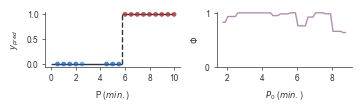

In [11]:
fig, axes = plt.subplots(1,2, figsize=(3.5, 1.0), sharex=False, constrained_layout=True)

cmap_bin = sns.color_palette("vlag", as_cmap=True, n_colors=2)
x0s = np.linspace(1.75, 8.75, endpoint=True)

for x_pred, y_pred in zip(decision_example_x, decision_example):
    axes[0].scatter(x_pred, y_pred, s=8, c=y_pred, cmap=cmap_bin, zorder=2, alpha=0.5)  

axes[0].vlines(5.75, 0, 1, ls='dashed', color=style.nord_base.dark[0],  lw=1.0, zorder=0)
axes[0].hlines(0, 0, 5.75, color=style.nord_base.dark[0], lw=1.0, zorder=0)
axes[0].hlines(1, 5.75, 10, color=style.nord_base.dark[0], lw=1.0, zorder=0)

axes[1].plot(x0s, decision_scores, c='C4')

axes[1].set_yticks([0, 1])
axes[0].set_xlabel(r"P ($min.$)")
axes[0].set_ylabel(r"$y_{pred}$")
axes[0].set_xticks([0, 2, 4, 6, 8, 10])
axes[1].set_xlabel(r"$P_0$ ($min.$)")
axes[1].set_ylabel(r"$\Phi$")

plt.savefig(f"../plots/sensor_light_switch.svg")

plt.show()